In [1]:
%matplotlib inline

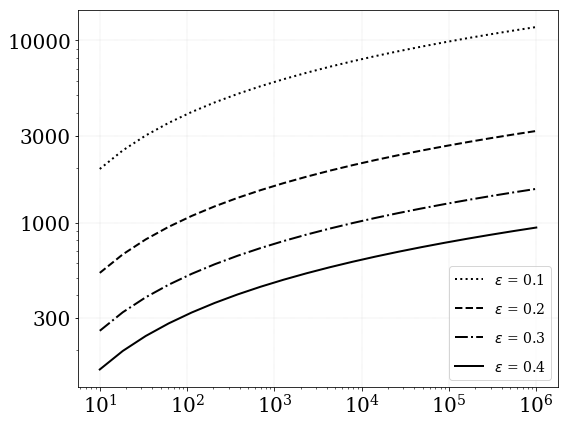

In [3]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.datasets import load_digits
from sklearn.metrics.pairwise import euclidean_distances

# Part 1: plot the theoretical dependency between n_components_min and
# n_samples

# range of admissible distortions
eps_range = [0.1, 0.2, 0.3, 0.4]
#colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(eps_range)))
line_styles = [':', '--', '-.', '-']
line_widths = [2, 2, 2, 2]
colors = [[0,0,0], [0,0,0], [0,0,0], [0,0,0]]

# range of number of samples (observation) to embed
n_samples_range = np.logspace(1, 6, 20)

jl_min_dim = lambda n, eps: 4.0 / (eps*eps/2.0 - eps*eps*eps/3.0) * np.log(n)
plt.figure(figsize=(8,6))
for eps, ls, lw, c in zip(eps_range, line_styles, line_widths, colors):
    #min_n_components = johnson_lindenstrauss_min_dim(n_samples_range, eps=eps)
    min_n_components = jl_min_dim(n_samples_range, eps=eps)
    plt.loglog(n_samples_range, min_n_components, c=c, ls=ls, lw=lw)
    #plt.semilogx(n_samples_range, min_n_components, c=c, ls=ls, lw=lw)


plt.legend(["$\\varepsilon$ = %0.1f" % eps for eps in eps_range],
           loc="lower right", fontsize=14, frameon=True, labelspacing=1)
#plt.xlabel("Number of observations to eps-embed")
#plt.ylabel("Minimum number of dimensions")
#plt.title("Johnson-Lindenstrauss bounds:\nn_samples vs n_components")
plt.grid(True, ls='--', lw=0.2)
plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
ax = plt.axes()
ax.set_yticks([300,1000,3000,10000])
ax.set_yticklabels([300,1000,3000,10000], fontsize=20)
#ax.set_xticks([0,0.25,0.5,0.75,1])
#ax.set_xticklabels([-1,-0.5,0,0.5,1], fontsize=20)
#axs = ax.twiny()
#axs.spines['bottom'].set_position(('outward', 36))
#axs.xaxis.set_ticks_position('bottom')
#axs.xaxis.set_label_position('bottom')
#axs.set_xticks([0,0.5,1])
#axs.set_xticklabels([0,0.5,1], fontsize=20)
plt.tight_layout()
#plt.rcParams['font.family'] = 'Times New Roman'
plt.rc('font', family='serif')

#plt.savefig('JL_min_dim.pdf', bbox_inches='tight', dpi=300)
#plt.savefig('JL_min_dim.eps', bbox_inches='tight', dpi=300)

## Part 2: perform sparse random projection of documents of the 20 newsgroups dataset which is both high dimensional and sparse

In [4]:
data20newsgroups = fetch_20newsgroups_vectorized().data[:500]
data = data20newsgroups[:32]
n_samples, n_features = data.shape
print("Embedding %d samples with dim %d using various random projections"
      % (n_samples, n_features))

Embedding 32 samples with dim 130107 using various random projections


Projected 32 samples from 130107 to 300 in 0.191s
Random matrix with size: 1.300MB
Mean distances rate: -0.12 (0.16)
Projected 32 samples from 130107 to 1000 in 0.672s
Random matrix with size: 4.323MB
Mean distances rate: -0.08 (0.08)
Projected 32 samples from 130107 to 10000 in 6.359s
Random matrix with size: 43.298MB
Mean distances rate: -0.01 (0.03)


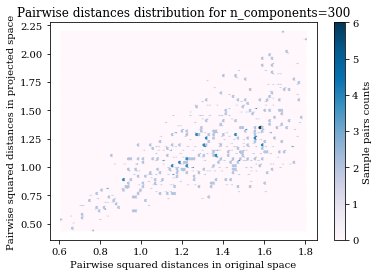

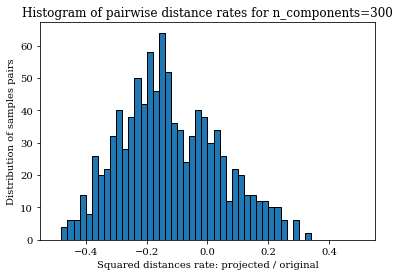

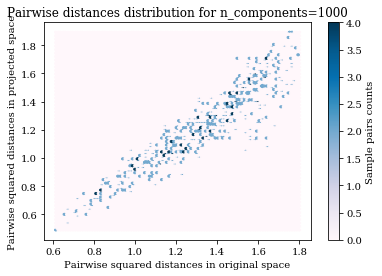

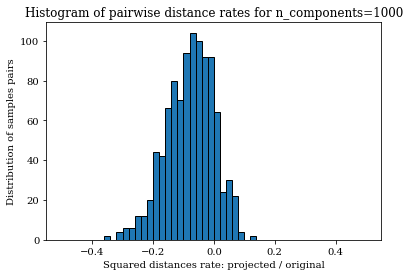

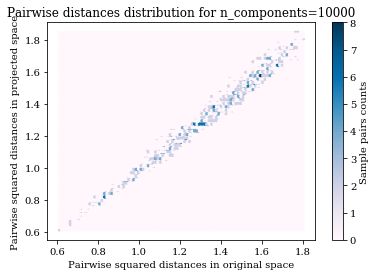

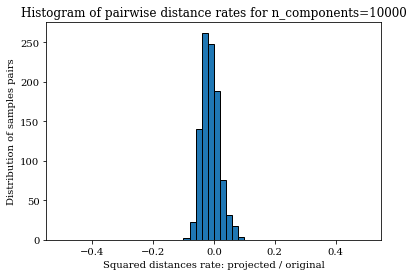

In [5]:
n_components_range = np.array([300, 1000, 10000])
dists = euclidean_distances(data, squared=True).ravel()

# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

#data = data.toarray()
for n_components in n_components_range:
    t0 = time()
    rp = SparseRandomProjection(n_components=n_components, dense_output=True)#,density=np.log(n_features)/n_features)
    projected_data = rp.fit_transform(data)
    #projected_data = np.zeros((data.shape[0], n_components), dtype=data.dtype)
    #for i in range(data.shape[0]):
    #    projected_data[i,:] = rp.fit_transform(np.atleast_2d(data[i])).ravel()

    print("Projected %d samples from %d to %d in %0.3fs"
          % (n_samples, n_features, n_components, time() - t0))
    if hasattr(rp, 'components_'):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print("Random matrix with size: %0.3fMB" % (n_bytes / 1e6))

    projected_dists = euclidean_distances(
        projected_data, squared=True).ravel()[nonzero]

    plt.figure()
    plt.hexbin(dists, projected_dists, gridsize=100, cmap=plt.cm.PuBu)
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" %
              n_components)
    cb = plt.colorbar()
    cb.set_label('Sample pairs counts')

    rates = projected_dists / dists - 1.0
    print("Mean distances rate: %0.2f (%0.2f)"
          % (np.mean(rates), np.std(rates)))

    plt.figure()
    plt.hist(rates, bins=50, range=(-0.5, 0.5), edgecolor='k')
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" %
              n_components)

plt.show()

Projected 32 samples from 130107 to 300 in 0.219s
Mean distances rate: -0.01 (0.09)
Projected 32 samples from 130107 to 1000 in 0.225s
Mean distances rate: 0.00 (0.04)
Projected 32 samples from 130107 to 10000 in 0.227s
Mean distances rate: -0.01 (0.01)


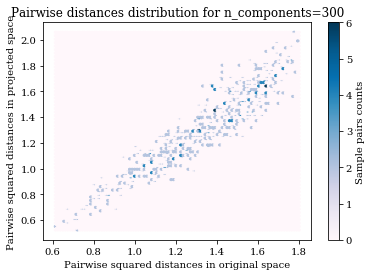

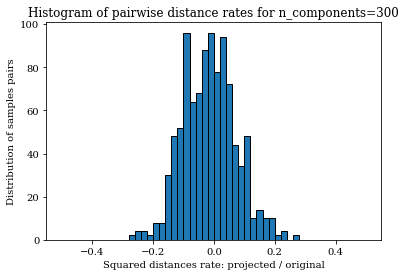

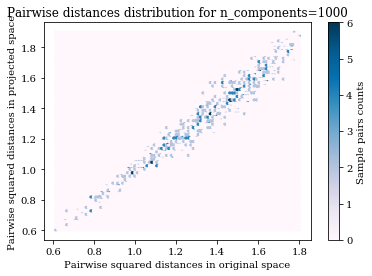

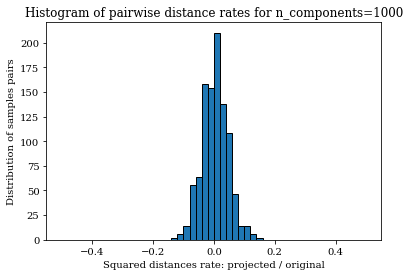

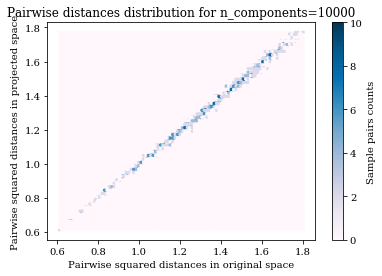

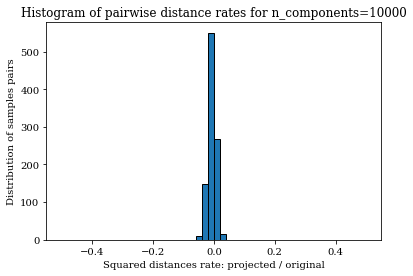

In [6]:
##
## Needs SPMLIB installed ##
##

import numpy as np
from spmlib.linalg import RandomProjection

n_components_range = np.array([300, 1000, 10000])
dists = euclidean_distances(data, squared=True).ravel()
# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

rp = RandomProjection(n_features)
for n_components in n_components_range:
    t0 = time()
    projected_data = np.zeros((data.shape[0], n_components))
    for i in range(data.shape[0]):
        projected_data[i] = rp.erp(data[i].toarray().ravel(), n_components)
    print("Projected %d samples from %d to %d in %0.3fs"
          % (n_samples, n_features, n_components, time() - t0))
    if hasattr(rp, 'components_'):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print("Random matrix with size: %0.3fMB" % (n_bytes / 1e6))

    projected_dists = euclidean_distances(
        projected_data, squared=True).ravel()[nonzero]

    plt.figure()
    plt.hexbin(dists, projected_dists, gridsize=100, cmap=plt.cm.PuBu)
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" %
              n_components)
    cb = plt.colorbar()
    cb.set_label('Sample pairs counts')

    rates = projected_dists / dists -1.0
    print("Mean distances rate: %0.2f (%0.2f)"
          % (np.mean(rates), np.std(rates)))

    plt.figure()
    plt.hist(rates, bins=50, range=(-0.5, 0.5), edgecolor='k')
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" %
              n_components)

    # TODO: compute the expected value of eps and add them to the previous plot
    # as vertical lines / region

plt.show()